### CNN 이미지 분류 모델
- 이미지 데이터셋 준비
	* torchvision의 내장 데이터셋 활용 CIFAR 10
- 이미지 분류 모델
	* 커스텀 CNN 구현

#### [1] 모듈 로딩 및 데이터 준비<hr>

In [20]:
# 모듈 로딩
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10				# torchvision 내장 데이터셋 관련 모듈
from torchvision.transforms import ToTensor				# torchvision 데이터 변환 관련 모듈
from torch.utils.data import DataLoader					# 데이터셋 관련 모듈 로딩딩

import matplotlib.pyplot as plt

In [21]:
# 데이터 준비
DIR_PATH = '../data/' 

# 파이토치 dataset 인스턴스 로딩 (텐서 형태로)
cifarDS = CIFAR10(DIR_PATH, train=True, download=True,
                  transform=ToTensor())

Files already downloaded and verified


In [22]:
type(cifarDS)

torchvision.datasets.cifar.CIFAR10

In [23]:
# cifarDS 속성 확인 
# class 속성
print(f'cifarDS.classes =>	{cifarDS.classes}\n' )
print(f'cifarDS.data.shape => {cifarDS.data.shape}' )
print(f'len(cifarDS.targets)=> {len(cifarDS.targets)}')
print(f'cifarDS.class_to_idx => {cifarDS.class_to_idx}' )

cifarDS.classes =>	['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifarDS.data.shape => (50000, 32, 32, 3)
len(cifarDS.targets)=> 50000
cifarDS.class_to_idx => {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


#### [2] 데이터 로더<hr>
- 학습 시 배치크기만큼 데이터와 라벨/타겟을 로딩

target tensor([6])
torch.Size([1, 3, 32, 32])
torch.Size([1])
data tensor([[[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 

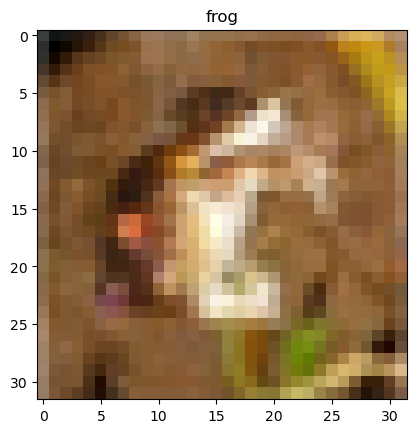

In [24]:
BATCH_SIZE = 50

# cifar10DL = DataLoader(cifarDS, batch_size=BATCH_SIZE)
cifar10DL = DataLoader(cifarDS)		# 배치 사이즈==1

# [테스트] Dataset & DataLoader
for data, target in cifar10DL:
    print("target",target)
    print(data.shape)				# torch.Size([1, 3, 32, 32]) --> 3: RGB 3개
    print(target.shape)
    print("data",data)
    data1=data.squeeze()
    print(data1.shape)				# torch.Size([3, 32, 32])
    plt.imshow(data1.transpose(0,2))
    plt.title(cifarDS.classes[target.item()])
    break

##### 이미지 데이터 형태로 shape 변환

In [25]:
# torch.Size([1, 3, 32, 32])
#		-> [32,32,3]으로 shape 변환 필요!!

In [26]:
try:
	data.item()
except Exception as e:
	print(e)

a Tensor with 3072 elements cannot be converted to Scalar


#### [3] 커스텀 모델 설계 및 정의 <hr>
- 모델 목적: 이미지 분류 모델
- 학습 방법: 지도학습 >> 분류 >> 다중분류 (10개)
- 클래스이름: ImageMCF
- 클래스구조: 특징추출부분 => CNN + 학습부분 FC
- 부모클래스: nn.Module
<hr>
* 초반에 kernel(out_features) 개수 많이 할당!! (피쳐 특성 많이 뽑기 위해)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class ImageMCF(nn.Module):

	# 모델 구조 설계, 생성자 메서드
	def __init__(self):
		# 부모 생성
		super().__init__()

		# 모델 층 구성 
		# 피쳐 맵 추출 층
		# 		
		#				[1,3,32,32]
		self.in_layer = nn.Conv2d(in_channels=3, out_channels=10,kernel_size=3)		# Valid padding
		#				[1,10,30,30]
		self.p_layer =nn.MaxPool2d(kernel_size=2)
		#				[1,10,15,15]

		'''
		self.in_layer = nn.Conv2d(3,10,3)
		self.in_layer = nn.Conv2d(10,50,3)
		self.in_layer = nn.Conv2d(50,10,3)
		'''

		# 학습 관련 층
		self.hd_layer = nn.Linear(1*10*15*15, 50)
		self.ot_layer = nn.Linear( 50, 10)

		# shape 변환 과정--------------------------------------------------------------
		# 원본 [1,3,32,32]	-> 이미지 변환 [3, 32,32] (채널, 행, 열)
		# 		-> Conv2d 후 [10,30,30] 
		#				(out_channels, 커널크기만큼 변환된 크기(30), 30)
		#		-> 배치사이즈만큼 [1,10,30,30]
		#					(배치사이즈 크기=>(1), )
		# ----------------------------------------------------------------------------


	# 전방향/순방향 학습 메서드
	def forward(self, in_put):

		# 이미지 특징 맵 추출
		output = self.in_layer(in_put)
		print(f'[output 1] {output.shape}')

		output = F.relu(output)
		print(f'[output 2] {output.shape}')

		output = self.p_layer(output)
		print(f'[output 3] {output.shape}')

		# 4d->2d (샘플수, 피쳐수)
		output = output.view(output.shape[0], -1)
		print(f'[output 4] {output.shape}')

		output = self.hd_layer(output)
		print(f'[output 5] {output.shape}')

		output = self.ot_layer(output)
		print(f'[output 6] {output.shape}')
		
		return output							# 손실함수에서 softmax 처리!! 
												# 따로 확률값 처리 필요 X



##### nn.Sequential로 Layer 묶기

In [29]:
## nn.Sequential로 묶기

class ImageMCF_2(nn.Module):

	# 모델 구조 설계, 생성자 메서드
	def __init__(self):
		# 부모 생성
		super().__init__()

		# 모델 층 구성 
		# 피쳐 맵 추출 층
		# 		
		#				[1,3,32,32]
		self.cnn_layer = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=10,kernel_size=3),		
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)

		self.cnn_layer2 = nn.Sequential(
			nn.Conv2d(in_channels=10, out_channels=30,kernel_size=3),		
			nn.ReLU(),										# 1,30,13,13
			nn.AvgPool2d(kernel_size=2,stride=2)			# 1,30,6,6
		)


		'''
		self.in_layer = nn.Conv2d(3,10,3)
		self.in_layer = nn.Conv2d(10,50,3)
		self.in_layer = nn.Conv2d(50,10,3)
		'''

		# 학습 관련 층
		self.hd_layer = nn.Linear(1*30*6*6, 50)
		self.ot_layer = nn.Linear( 50, 10)

		# shape 변환 과정--------------------------------------------------------------
		# 원본 [1,3,32,32]	-> 이미지 변환 [3, 32,32] (채널, 행, 열)
		# 		-> Conv2d 후 [10,30,30] 
		#				(out_channels, 커널크기만큼 변환된 크기(30), 30)
		#		-> 배치사이즈만큼 [1,10,30,30]
		#					(배치사이즈 크기=>(1), )
		# ----------------------------------------------------------------------------


	# 전방향/순방향 학습 메서드
	def forward(self, in_put):

		# 이미지 특징 맵 추출
		output = self.cnn_layer(in_put)
		print(f'[cnn_layer output] {output.shape}')

		output = self.cnn_layer2(output)
		print(f'[cnn_layer2 output] {output.shape}')
		

		# 4d->2d (샘플수, 피쳐수)
		output = output.view(output.shape[0], -1)
		print(f'[view output] {output.shape}')

		output = self.hd_layer(output)
		print(f'[hd_layer output] {output.shape}')

		output = self.ot_layer(output)
		print(f'[ot_layer output] {output.shape}')
		
		return output							# 손실함수에서 softmax 처리!! 
												# 따로 확률값 처리 필요 X

In [30]:
# 사용자 정의 모델 테스트
model = ImageMCF()
model2 = ImageMCF_2()

In [31]:
## 인스턴스 속성 변수 ==> 인스턴스변수명.속성명=새로운값
model.out_layer=nn.Linear(10,50)
for name,param in model.out_layer.named_parameters():
    print(name,param,sep='\n')

weight
Parameter containing:
tensor([[-0.0647,  0.0503, -0.1399,  0.1378,  0.2183,  0.1300, -0.1824, -0.0782,
         -0.0661, -0.2249],
        [-0.2892,  0.1836,  0.0496,  0.0383, -0.0968,  0.1068,  0.2825, -0.1387,
         -0.2960,  0.2824],
        [-0.2570,  0.1249,  0.1458, -0.3069, -0.2049, -0.2689,  0.1310, -0.2457,
          0.2447, -0.1453],
        [-0.1269, -0.1476, -0.2728,  0.2551,  0.0537, -0.1247, -0.1778,  0.0304,
         -0.3099,  0.1550],
        [ 0.2811,  0.1095, -0.0356,  0.1661,  0.0993,  0.2427,  0.1315, -0.1636,
          0.0790, -0.2822],
        [-0.1398,  0.0025, -0.1396,  0.2590,  0.0688,  0.1049, -0.2514, -0.1323,
         -0.1118,  0.1313],
        [-0.0242, -0.1498,  0.2571, -0.2626, -0.2746,  0.0784,  0.1610,  0.3133,
          0.1269, -0.1344],
        [-0.0496, -0.1608,  0.2359, -0.2342, -0.2405, -0.2637,  0.2030,  0.1431,
          0.2249, -0.0327],
        [ 0.1437,  0.1113, -0.0078,  0.0474,  0.0858, -0.1199, -0.2766,  0.2868,
          0.2038, 

In [32]:
# %pip install torchinfo

In [33]:
from torchinfo import summary

# summary(model)
print(model2)
summary(model2)

ImageMCF_2(
  (cnn_layer): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer2): Sequential(
    (0): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (hd_layer): Linear(in_features=1080, out_features=50, bias=True)
  (ot_layer): Linear(in_features=50, out_features=10, bias=True)
)


Layer (type:depth-idx)                   Param #
ImageMCF_2                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,730
│    └─ReLU: 2-5                         --
│    └─AvgPool2d: 2-6                    --
├─Linear: 1-3                            54,050
├─Linear: 1-4                            510
Total params: 57,570
Trainable params: 57,570
Non-trainable params: 0

In [34]:
# 테스트
for data, target in cifar10DL:
    print(f'[target] => {target}')
    print(data.shape)
    
	# 학습
    preTarget = model(data)
    print(f'pre => {preTarget.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[output 1] torch.Size([1, 10, 30, 30])
[output 2] torch.Size([1, 10, 30, 30])
[output 3] torch.Size([1, 10, 15, 15])
[output 4] torch.Size([1, 2250])
[output 5] torch.Size([1, 50])
[output 6] torch.Size([1, 10])
pre => tensor([9])


In [35]:
# 테스트
for data, target in cifar10DL:
    print(f'[target] => {target}')
    print(data.shape)
    
	# 학습
    preTarget = model2(data)
    print(f'pre => {preTarget.argmax(dim=1)}')
    break

[target] => tensor([6])
torch.Size([1, 3, 32, 32])
[cnn_layer output] torch.Size([1, 10, 15, 15])
[cnn_layer2 output] torch.Size([1, 30, 6, 6])
[view output] torch.Size([1, 1080])
[hd_layer output] torch.Size([1, 50])
[ot_layer output] torch.Size([1, 10])
pre => tensor([2])


In [36]:
# 모델 파라미터 확인
for name, param in model.named_parameters():
    print(f'[{name}]----------\n{param.shape}\n')

[in_layer.weight]----------
torch.Size([10, 3, 3, 3])

[in_layer.bias]----------
torch.Size([10])

[hd_layer.weight]----------
torch.Size([50, 2250])

[hd_layer.bias]----------
torch.Size([50])

[ot_layer.weight]----------
torch.Size([10, 50])

[ot_layer.bias]----------
torch.Size([10])

[out_layer.weight]----------
torch.Size([50, 10])

[out_layer.bias]----------
torch.Size([50])

